# how many novel lncRNAs are quantified?

evidence that the new lncRNAs are expressed/quantifiable in v10 vs v11.

v10 used gencode 46 with 19000 lncRNAs, v11 uses gencode 47 with 35000 lncRNAs

In [ ]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from matplotlib.colors import LogNorm
from scipy import stats
import os

from tqdm.notebook import tqdm

tqdm.pandas()

/local/scratch/klawren/slrmtmp.47796407/ipykernel_16995/889698852.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


### load in gencode gene ids and groups

In [ ]:
gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', sep='\t')

/local/scratch/klawren/slrmtmp.47796407/ipykernel_16995/2754484914.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', sep='\t')


## TPM comparision

In [ ]:
v10_quantificaiton_path = "/home/klawren/oak/gtex/data/other_references/v10/gene_tpm_v10_brain_caudate_basal_ganglia.gct.gz"
v11_quantificaiton_dir = "/home/klawren/oak/gtex/output/caudate_analysis"

### comparison of lnc RNAs we detect

In [ ]:
tpm_cutoff=.1
gene_type_order = ['lncRNA', 'protien_coding', 'pseudogene', 'noncoding_RNA', 'artifact']

gene_type_pal = {'lncRNA':'#b70657',
                 'protien_coding':'#215B30',
                 'noncoding_RNA':'#6A5ACD',
                 'pseudogene':'#005BBF',
                 'artifact':'#7a7a7a'}


highlight_gene_type_pal = {'new_lncRNA':'#fb7cb6', 
                           'lncRNA':'#b70657',
                 'protien_coding':'#215B30',
                 'noncoding_RNA':'#6A5ACD',
                 'pseudogene':'#005BBF',
                 'artifact':'#7a7a7a'}

In [ ]:
# aggregate quantifications from the output directory
# final output should be dataframe with sample_id as columns and gene_tpm

def agg_rnaseqc(output_dir, file_end='.gene_tpm.gct.gz'):
    sample_tpms = []
    for filename in os.listdir(os.path.join(output_dir, 'rnaseq_qc')):
            if filename.endswith(file_end):
                print(filename)
                sample_tpms.append(pd.read_csv(os.path.join(output_dir, f'rnaseq_qc/{filename}'), sep='\t', skiprows=2).set_index(['Name', 'Description']))

    tpm_agg = pd.concat(sample_tpms, axis=1).reset_index()
    return tpm_agg

In [ ]:
# tpm_v11 = agg_rnaseqc(v11_quantificaiton_dir)
# tpm_v11.to_csv('/home/klawren/oak/gtex/output/caudate_analysis/gene_tpm_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t', index=None)
tpm_v11 = pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/gene_tpm_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t')
tpm_v11['gene_id_stable'] = tpm_v11['Name'].str.split('.').str[0]
tpm_v11 = tpm_v11.set_index('gene_id_stable').drop(columns=['Name', 'Description'])
tpm_v11.head()

,GTEX-13PL6-0011-R5b-SM-5O9BI,GTEX-1EH9U-0011-R5a-SM-CJI2K,GTEX-13OW7-0011-R5b-SM-5O9DM,GTEX-12584-0011-R5b-SM-GIN96,GTEX-UTHO-0011-R5A-SM-G8W6H,GTEX-13VXU-0011-R5a-SM-5O9D7,GTEX-11GSP-0011-R5a-SM-57WBE,GTEX-NL3H-0011-R5a-SM-2I3GB,GTEX-T2IS-0011-R5A-SM-32QP4,GTEX-14BIM-0011-R5b-SM-5S2RM,...,GTEX-1N2EE-0011-R5a-SM-EY5YF,GTEX-11NV4-0011-R5a-SM-5NQ88,GTEX-1192W-0011-R5a-SM-GI4VY,GTEX-1GZ2Q-0011-R5a-SM-A96RQ,GTEX-WL46-0011-R5A-SM-3LK6V,GTEX-11DXY-0011-R5b-SM-DNZZL,GTEX-12ZZZ-0011-R5a-SM-5EQ4M,GTEX-11ONC-0011-R5b-SM-DO93I,GTEX-13N1W-0011-R5b-SM-5MR5Q,GTEX-1KD4Q-0011-R5a-SM-EY5Y8
gene_id_stable,,,,,,,,,,,,,,,,,,,,,
ENSG00000290825,0.016976,0.000000,0.000000,0.000000,0.011532,0.000000,0.000000,0.015858,0.011970,0.054965,...,0.000000,0.000000,0.000000,0.01603,0.000000,0.014490,0.019261,0.000000,0.035504,0.011702
ENSG00000223972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000310526,0.570455,0.362674,0.854803,0.413729,1.291690,0.480483,1.053108,1.494747,0.485710,3.008647,...,1.381221,1.126558,0.585683,0.84693,1.096104,0.912594,0.765295,0.849347,1.763305,0.420427
ENSG00000243485,0.029428,0.015024,0.015720,0.018853,0.000000,0.000000,0.000000,0.000000,0.020749,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000237613,0.064292,0.009378,0.029438,0.035304,0.012478,0.013977,0.026174,0.051477,0.000000,0.000000,...,0.015645,0.000000,0.000000,0.00000,0.000000,0.000000,0.020842,0.000000,0.019208,0.037986


In [ ]:
# load in tpm quantification for v10
tpm_v10 = pd.read_csv(v10_quantificaiton_path, sep='\t', skiprows=2)
tpm_v10['gene_id_stable'] = tpm_v10['Name'].str.split('.').str[0]
tpm_v10 = tpm_v10.set_index('gene_id_stable').drop(columns=['Name', 'Description'])
tpm_v10.head()

,GTEX-1117F-0011-R5a-SM-GI4VW,GTEX-111FC-0011-R5a-SM-GIN8L,GTEX-117XS-0011-R5b-SM-GJ3PP,GTEX-1192W-0011-R5a-SM-GI4VY,GTEX-1192X-0011-R5a-SM-DNZZA,GTEX-11DXW-0011-R5b-SM-DO11D,GTEX-11DXY-0011-R5b-SM-DNZZL,GTEX-11DYG-0011-R5a-SM-DO928,GTEX-11DZ1-0011-R5a-SM-DO11J,GTEX-11EI6-0011-R5a-SM-GINAM,...,GTEX-ZE9C-0011-R5a-SM-5EGLO,GTEX-ZF28-0011-R5a-SM-4WWCZ,GTEX-ZUA1-0011-R5b-SM-51MTG,GTEX-ZV68-0011-R5a-SM-4YCDW,GTEX-ZVT3-0011-R5a-SM-51MSI,GTEX-ZVZQ-0011-R5b-SM-57WDC,GTEX-ZXG5-0011-R5b-SM-57WBN,GTEX-ZYFD-0011-R5a-SM-H6Q7M,GTEX-ZYY3-0011-R5a-SM-H7OGH,GTEX-ZZPT-0011-R5a-SM-GPRX5
gene_id_stable,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.011513,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.033181,0.013432,0.010025,0.012049,0.025464
ENSG00000227232,3.51443,3.443050,2.843570,2.49813,2.098910,0.799514,2.53661,1.20675,1.36110,1.244180,...,0.774938,2.06256,1.604420,1.209580,1.01061,1.814390,1.923700,1.109440,1.302020,1.624510
ENSG00000278267,0.00000,0.365439,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000243485,0.00000,0.028695,0.057756,0.00000,0.058521,0.043787,0.00000,0.00000,0.02783,0.000000,...,0.086953,0.00000,0.119049,0.033725,0.00000,0.033123,0.000000,0.000000,0.024056,0.025420
ENSG00000237613,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.016330,...,0.020591,0.00000,0.000000,0.047918,0.00000,0.023531,0.000000,0.000000,0.000000,0.000000


In [ ]:
# check v10 gene_ids are all in v39 gencode
print('{} v10 gene ids aren\'t in gencode v39'.format(sum(~tpm_v10.index.isin(gencode_ids[~gencode_ids['gene_id_v39'].isna()]['gene_id_stable']))))
print('{} v11 gene ids aren\'t in gencode v39'.format(sum(~tpm_v11.index.isin(gencode_ids[~gencode_ids['gene_id_v39'].isna()]['gene_id_stable']))))

# check v11 gene_ids are all in v47 gencode
print('{} v11 gene ids aren\'t in gencode v47'.format(sum(~tpm_v11.index.isin(gencode_ids[~gencode_ids['gene_id_v47'].isna()]['gene_id_stable']))))
print('{} v10 gene ids aren\'t in gencode v47'.format(sum(~tpm_v10.index.isin(gencode_ids[~gencode_ids['gene_id_v47'].isna()]['gene_id_stable']))))

# get only the sample ids in both (should be all of them)
v10_sample_ids = tpm_v10.columns
v11_sample_ids = tpm_v11.columns

# TODO confirm that all samples match between v10 and v11
print('{} v10 sample ids arent in v11'.format(len(v10_sample_ids[~v10_sample_ids.isin(v11_sample_ids)])))
print('{} v11 sample ids arent in v10'.format(len(v11_sample_ids[~v11_sample_ids.isin(v10_sample_ids)])))

both_ids = v11_sample_ids[v11_sample_ids.isin(v10_sample_ids)]
print('{} ids in both'.format(len(both_ids)))
v10_sample_ids = both_ids
v11_sample_ids = both_ids


0 v10 gene ids aren't in gencode v39
18053 v11 gene ids aren't in gencode v39
0 v11 gene ids aren't in gencode v47
1144 v10 gene ids aren't in gencode v47
0 v10 sample ids arent in v11
22 v11 sample ids arent in v10
300 ids in both


In [ ]:
# get median tpm for v10
v10_median_tpm = pd.DataFrame({'tpm':tpm_v10[v10_sample_ids].median(axis=1)}).reset_index()
v10_median_tpm = pd.merge(left=v10_median_tpm, right=gencode_ids[['gene_id_stable', 'gene_type_grouped']], on='gene_id_stable', how='left')
v10_median_tpm['quantified'] = v10_median_tpm['tpm']>tpm_cutoff

Text(0.15000000000000002, 1620.675, 'quantified')

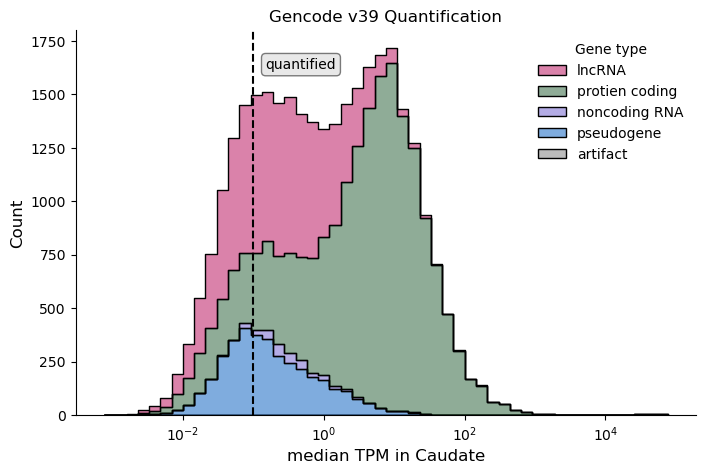

In [ ]:
# v10 distribution
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(v10_median_tpm, x='tpm', hue='gene_type_grouped', bins=50, log_scale=True, element='step', fill=True, ax=ax, palette=gene_type_pal, multiple='stack', alpha=.5,
             hue_order=list(highlight_gene_type_pal.keys())[1:])

ax.set_xlabel('median TPM in Caudate', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('Gencode v39 Quantification')


# Customize the legend
legend = ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
legend.get_frame().set_visible(False)
legend.set_title("Gene type")

ax.axvline(tpm_cutoff, color='k', linestyle='--')
ax.text(tpm_cutoff+.05, ax.get_ylim()[1] * 0.9, 'quantified', horizontalalignment='left', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))
# ax.text(tpm_cutoff-.03, ax.get_ylim()[1] * 0.9, 'un-quantified', horizontalalignment='right', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))


In [ ]:
# get v11 data
v11_median_tpm = pd.DataFrame({'tpm':tpm_v11[v11_sample_ids].median(axis=1)}).reset_index()
v11_median_tpm = pd.merge(left=v11_median_tpm, right=gencode_ids[['gene_id_stable', 'gene_type_grouped', 'match_level']], on='gene_id_stable', how='left')
# get a list of the new lncRNAs
new_lncrnas = gencode_ids[(gencode_ids['gene_type_grouped']=='lncRNA') &( gencode_ids['match_level']=='unique_v47')]['gene_id_stable']

# add info about new lncRNAs
v11_median_tpm['new_highlight_gene_type'] = np.where(v11_median_tpm['gene_id_stable'].isin(new_lncrnas), 'new_lncRNA', v11_median_tpm['gene_type_grouped'])
v11_median_tpm['quantified'] = v11_median_tpm['tpm']>tpm_cutoff

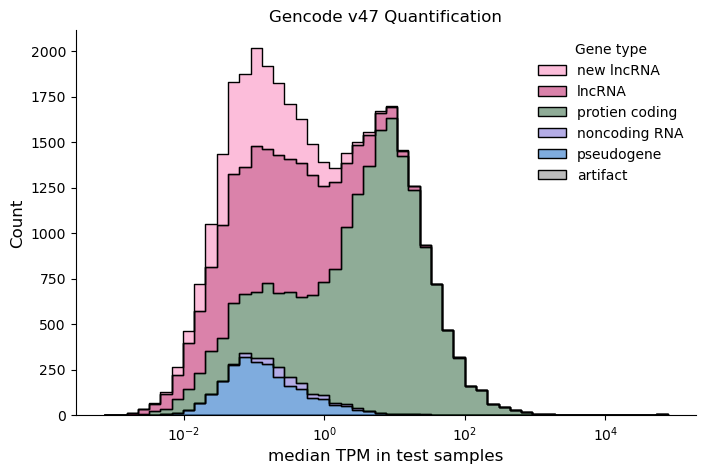

In [ ]:
# v11 distribution
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(v11_median_tpm, x='tpm', hue='new_highlight_gene_type', bins=50, log_scale=True, element='step', fill=True, ax=ax, palette=highlight_gene_type_pal, multiple='stack', alpha=.5,
             hue_order=list(highlight_gene_type_pal.keys()))

ax.set_xlabel('median TPM in test samples', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('Gencode v47 Quantification')

# Customize the legend
legend = ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
legend.get_frame().set_visible(False)
legend.set_title("Gene type")

# ax.axvline(tpm_cutoff, color='k', linestyle='--')
# ax.text(tpm_cutoff+.05, ax.get_ylim()[1] * 0.9, 'quantified', horizontalalignment='left', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))
# ax.text(tpm_cutoff-.03, ax.get_ylim()[1] * 0.9, 'un-quantified', horizontalalignment='right', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))


In [ ]:
# combine the two versions
median_tpm_combined = pd.merge(left=v10_median_tpm, right=v11_median_tpm, on='gene_id_stable', suffixes=['_v10', '_v11'], how='outer')
median_tpm_combined['quantified_v10'] = median_tpm_combined['quantified_v10'].fillna(False)
median_tpm_combined['quantified_v11'] = median_tpm_combined['quantified_v11'].fillna(False)
median_tpm_combined = pd.merge(median_tpm_combined[['quantified_v10', 'quantified_v11', 'gene_id_stable']], gencode_ids[['gene_id_stable', 'gene_type_grouped', 'match_level']], on='gene_id_stable', how='left')

# rename for upset plot
quantified_median_tpm = median_tpm_combined[(median_tpm_combined['quantified_v10']) | (median_tpm_combined['quantified_v11'])]
quantified_median_tpm = quantified_median_tpm.rename(columns={'quantified_v10':'v10','quantified_v11':'v11'})
upset_tpm_bool = quantified_median_tpm.set_index('v10').set_index('v11', append=True)

dict_keys(['matrix', 'shading', 'totals', 'extra0'])


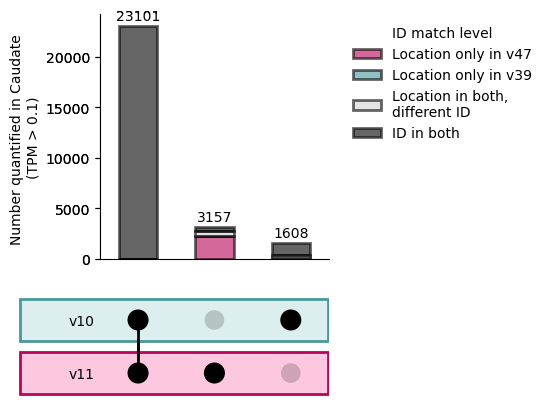

In [ ]:
fig = plt.figure(figsize=(4,5))

upset = up.UpSet(upset_tpm_bool, intersection_plot_elements=0, totals_plot_elements=0, show_counts=True, element_size=None, sort_by="cardinality")  # disable the default bar chart
upset.add_stacked_bars(by="match_level", title="", elements=4, colors=['black', 'lightgrey', '#4a989c', '#b70657'])
plot_result = upset.plot(fig=fig)

# add category colors
upset.style_categories("v10", shading_edgecolor='#4a989c', shading_linewidth=2, shading_facecolor='#ddeeef')
upset.style_categories("v11", shading_edgecolor='#b70657', shading_linewidth=2, shading_facecolor='#fdc7e0')

# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

# style the stacked bar plot
stackedbar_plot = plot_result["extra0"]
stackedbar_plot.grid(False)
stackedbar_plot.set_ylabel("Number quantified in Caudate \n(TPM > 0.1)")
stackedbar_plot.spines['bottom'].set_visible(True)

# Customize the bars to have an alpha transparency and black outlines
for bar in stackedbar_plot.patches:
    bar.set_edgecolor('black')  # Add black edge outline
    bar.set_linewidth(2)  # Set the width of the edge outline
    bar.set_alpha(0.6)  # Set transparency
    
# add a legend
plt.legend(labels=['Location only in v47', 'Location only in v39', 'Location in both,\ndifferent ID', 'ID in both'], bbox_to_anchor=(1.05, 1), loc='upper left', title='ID match level')
leg = plt.gca().get_legend()
leg.set_frame_on(False)

plt.show()

dict_keys(['matrix', 'shading', 'totals', 'extra0'])


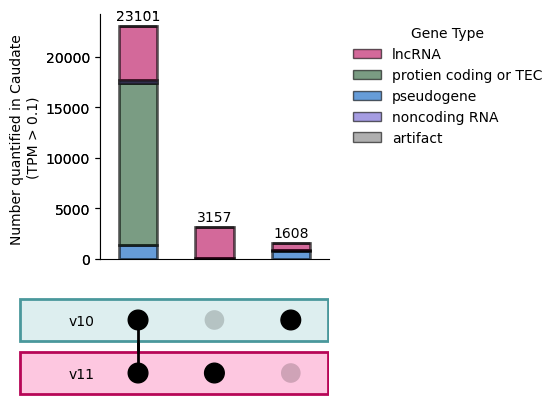

In [ ]:
fig = plt.figure(figsize=(4,5))

upset = up.UpSet(upset_tpm_bool, intersection_plot_elements=0, totals_plot_elements=0, show_counts=True, element_size=None, sort_by="cardinality")  # disable the default bar chart
upset.add_stacked_bars(by="gene_type_grouped", title="", elements=4, colors=gene_type_pal, )
plot_result = upset.plot(fig=fig)

# add category colors
upset.style_categories("v10", shading_edgecolor='#4a989c', shading_linewidth=2, shading_facecolor='#ddeeef')
upset.style_categories("v11", shading_edgecolor='#b70657', shading_linewidth=2, shading_facecolor='#fdc7e0')

# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

# style the stacked bar plot
stackedbar_plot = plot_result["extra0"]
stackedbar_plot.grid(False)
stackedbar_plot.set_ylabel("Number quantified in Caudate \n(TPM > 0.1)")
stackedbar_plot.spines['bottom'].set_visible(True)

# Customize the bars to have an alpha transparency and black outlines
for bar in stackedbar_plot.patches:
    bar.set_edgecolor('black')  # Add black edge outline
    bar.set_linewidth(2)  # Set the width of the edge outline
    bar.set_alpha(0.6)  # Set transparency
    
# optional add bar labels
# for container in stackedbar_plot.containers:
#     stackedbar_plot.bar_label(container, label_type='center', color='k', rotation=45, fontsize=5)


# add a legend
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=gene_type_pal[gene_type], edgecolor='k', alpha=.6) for gene_type in gene_type_order]
labels = [label.replace('_', ' ') for label in gene_type_order]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Gene Type')
leg = plt.gca().get_legend()
leg.set_frame_on(False)

plt.show()


In [ ]:
def ridgeline(data, overlap=0, fill=True, use_labels=False, labels=None, n_points=150, colors=None, zorder=0, edgecolor='k', ax=None):
    """
    Creates a standard ridgeline plot.

    data, list of lists.
    overlap, overlap between distributions. 1 max overlap, 0 no overlap.
    fill, use color to fill the distributions?
    use_labels, use y axis labels?
    labels, values to place on the y axis to describe the distributions.
    n_points, number of points to evaluate each distribution function.
    colors, single or list for each distribution
    zorder, offest all items up or down
    edgecolor, for the distributions
    """
    if ax == None:
        fig, ax = plt.subplots(figsize=(8,5))
    if colors == None:
        colors=['blue']*len(data)

    if overlap > 1 or overlap < 0:
        raise ValueError('overlap must be in [0 1]')
    xx = np.linspace(np.min(np.concatenate(data)),
                     np.max(np.concatenate(data)), n_points)
    ys = []
    for i, d in enumerate(data):
        pdf = gaussian_kde(d)
        y = i*(1.0-overlap)
        ys.append(y)
        curve = pdf(xx)
        if fill:
            ax.fill_between(xx, np.ones(n_points)*y, 
                             curve+y, zorder=len(data)-i+1+zorder, color=colors[i], alpha=.6)
        ax.plot(xx, curve+y, c=edgecolor, zorder=len(data)-i+1+zorder, lw=2)
    if use_labels:
        ax.set_yticks(ys, labels)
        ax.yaxis.set_tick_params(length=0)
        for tick, color in zip(ax.yaxis.get_major_ticks(), colors):
            tick.label1.set_color(color)

    ax.spines[['top', 'right', 'left']].set_visible(False)

    return ax

In [ ]:
ridgeline_grouped_v10 = v10_median_tpm[v10_median_tpm['tpm']>0].groupby('gene_type_grouped').agg({'tpm':list}).reset_index().iloc[1:]
# TODO this iloc bit drops aritfact as a category, confirm it is still doing that if input data changes
ridgeline_grouped_v11 = v11_median_tpm[v11_median_tpm['tpm']>0].groupby('gene_type_grouped').agg({'tpm':list}).reset_index().iloc[1:]

In [ ]:
def alpha_blending(hex_color, alpha) :
    """ alpha blending as if on the white background.
    """
    foreground_tuple  = hex2color(hex_color)
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return(final)

gene_type_colors = [alpha_blending(gene_type_pal[gene_type], .7) for gene_type in ridgeline_grouped_v10['gene_type_grouped'].values]
gene_type_colors_light = [alpha_blending(gene_type_pal[gene_type], .3) for gene_type in ridgeline_grouped_v10['gene_type_grouped'].values]


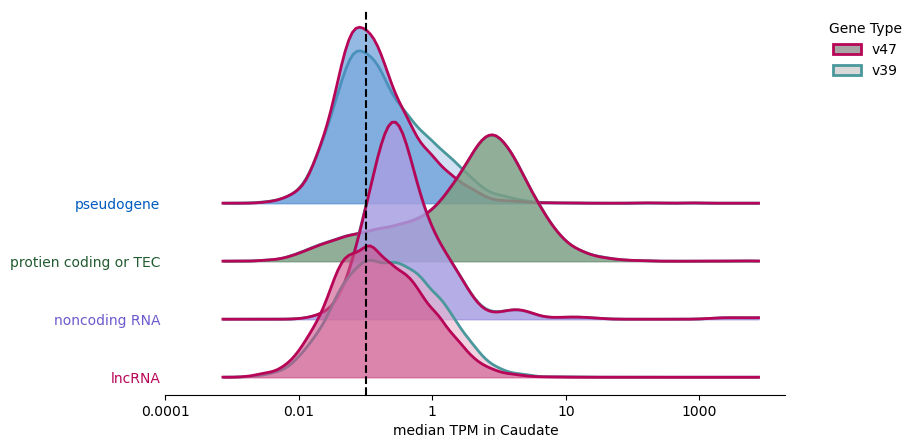

In [ ]:
pretty_ylabels = [label.replace('_', ' ') for label in ridgeline_grouped_v10['gene_type_grouped'].values]
ax = ridgeline([np.log10(tpm) for tpm in ridgeline_grouped_v10['tpm'].values], overlap=.75, fill='y', use_labels=True, labels=pretty_ylabels, colors=gene_type_colors_light, zorder=0, edgecolor='#4a989c')
ridgeline([np.log10(tpm) for tpm in ridgeline_grouped_v11['tpm'].values], overlap=.75, fill='y', use_labels=True, labels=pretty_ylabels, colors=gene_type_colors, ax=ax, zorder=.5,  edgecolor='#b70657')

ax.axvline(np.log10(tpm_cutoff), color='k', linestyle='--', zorder=10)
ax.set_xlabel('median TPM in Caudate')

ax.set_xticks([-4, -2, 0, 2, 4], labels=['0.0001', '0.01', '1', '10', '1000'])


# add a legend
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=fc, edgecolor=ec, linewidth=2) for fc, ec in zip([alpha_blending('grey', .7), alpha_blending('grey', .3)], ['#b70657', '#4a989c'])]
labels = ['v47', 'v39']
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Gene Type')
leg = plt.gca().get_legend()
leg.set_frame_on(False)

# make colors darker
for tick, color in zip(ax.yaxis.get_major_ticks(), [gene_type_pal[gene_type] for gene_type in ridgeline_grouped_v10['gene_type_grouped'].values]):
    tick.label1.set_color(color)

plt.show()


#### scatterplot of quantification in one vs the other

In [ ]:
median_tpm_combined = pd.merge(left=v10_median_tpm, right=v11_median_tpm, on='gene_id_stable', suffixes=['_v10', '_v11'], how='outer')
# fill with 1e-10 for ones that don't exist
median_tpm_combined[['tpm_v10', 'tpm_v11']] = median_tpm_combined[['tpm_v10', 'tpm_v11']].fillna(1e-7)
# fill with 1e-5 for ones that exist but weren't found
median_tpm_combined[['tpm_v10', 'tpm_v11']] = median_tpm_combined[['tpm_v10', 'tpm_v11']].replace(0, 1e-5)

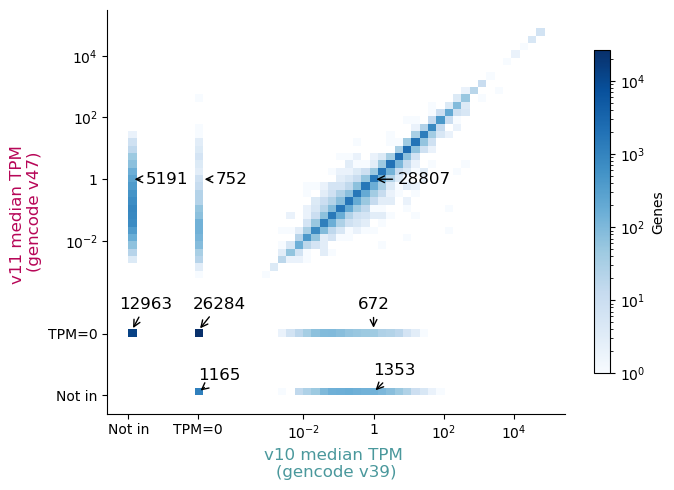

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(median_tpm_combined, x='tpm_v10', y='tpm_v11', bins=50, norm=LogNorm(), vmin=None, vmax=None, cbar=True, log_scale=True, cmap=sns.color_palette("Blues", as_cmap=True), ax=ax, cbar_kws={'shrink':.8, 'label':'Genes'})

ax.set_xlabel('v10 median TPM \n(gencode v39)', color='#4a989c', fontsize=12)
ax.set_ylabel('v11 median TPM \n(gencode v47)', color='#b70657', fontsize=12)

ax.set_xticks([1e-7, 1e-5, 1e-2, 1, 1e2, 1e4], labels=['Not in', 'TPM=0', r'$10^{-2}$', 1, r'$10^{2}$', r'$10^{4}$'])
ax.set_yticks([1e-7, 1e-5, 1e-2, 1, 1e2, 1e4], labels=['Not in', 'TPM=0', r'$10^{-2}$', 1, r'$10^{2}$', r'$10^{4}$'])

ax.spines[['top', 'right']].set_visible(False)

# add labels to the number of things in each group
ax.annotate(len(median_tpm_combined[(median_tpm_combined['tpm_v10']==1e-7)&(median_tpm_combined['tpm_v11']==1e-5)]), xy=(10**(-6.9),10**(-4.9)), xytext=(10**(-6.5), 10**(-4.2)),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, horizontalalignment='center')

ax.annotate(len(median_tpm_combined[(median_tpm_combined['tpm_v10']==1e-5)&(median_tpm_combined['tpm_v11']==1e-5)]), xy=(10**(-5),10**(-4.9)), xytext=(10**(-4.4), 10**(-4.2)),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, horizontalalignment='center')

ax.annotate(len(median_tpm_combined[(median_tpm_combined['tpm_v10']==1e-5)&(median_tpm_combined['tpm_v11']==1e-7)]), xy=(10**(-5),10**(-6.9)), xytext=(10**(-4.4), 10**(-6.5)),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, horizontalalignment='center')


ax.annotate(len(median_tpm_combined[(median_tpm_combined['tpm_v10']>1e-5)&(median_tpm_combined['tpm_v11']==1e-5)]), xy=(1,10**(-4.9)), xytext=(1, 10**(-4.2)),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, horizontalalignment='center')

ax.annotate(len(median_tpm_combined[(median_tpm_combined['tpm_v10']==1e-7)&(median_tpm_combined['tpm_v11']>1e-5)]), xy=(10**(-6.9),1), xytext=(10**(-6.5),1),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, verticalalignment='center')

ax.annotate(len(median_tpm_combined[(median_tpm_combined['tpm_v10']==1e-5)&(median_tpm_combined['tpm_v11']>1e-5)]), xy=(10**(-4.9),1), xytext=(10**(-4.5),1),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, verticalalignment='center')

ax.annotate(len(median_tpm_combined[(median_tpm_combined['tpm_v10']>1e-5)&(median_tpm_combined['tpm_v11']==1e-7)]), xy=(1, 10**(-6.9)), xytext=(1, 10**(-6.2)),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, verticalalignment='center')

ax.annotate(len(median_tpm_combined[(median_tpm_combined['tpm_v10']>1e-5)&(median_tpm_combined['tpm_v11']>1e-5)]), xy=(1,1), xytext=(5,1),
             arrowprops=dict(facecolor='grey', arrowstyle='->'),
             fontsize=12, verticalalignment='center')


fig.tight_layout()

### compare to null distribution 

In [ ]:
# v11_counts = agg_rnaseqc(v11_quantificaiton_dir, file_end='.gene_reads.gct.gz')
# v11_counts.to_csv(f'{v11_quantificaiton_dir}/gene_reads_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t', index=None)

v11_counts = pd.read_csv(f'{v11_quantificaiton_dir}/gene_reads_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t')
v11_counts['gene_id_stable'] = v11_counts['Name'].str.split('.').str[0]
v11_counts = v11_counts.set_index('gene_id_stable').drop(columns=['Name', 'Description'])
v11_sample_ids = v11_counts.columns

In [ ]:
#aggregate counts
null_quantificaiton_dir = "/home/klawren/oak/gtex/output/caudate_nongenic_null/v11_intergenic"
# null_counts = agg_rnaseqc(null_quantificaiton_dir, file_end='.gene_reads.gct.gz')
# null_counts.to_csv(f'{null_quantificaiton_dir}/null_gene_reads_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t', index=None)

null_counts = pd.read_csv(f'{null_quantificaiton_dir}/null_gene_reads_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t')
null_counts['gene_id_stable'] = null_counts['Name'].str.split('.').str[0]
null_counts = null_counts.set_index('gene_id_stable').drop(columns=['Name', 'Description'])
null_sample_ids = null_counts.columns

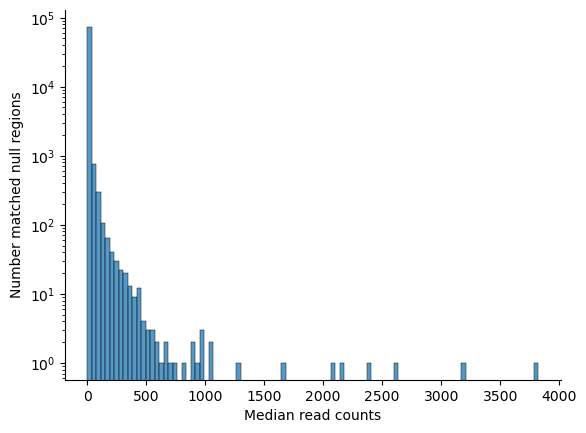

In [ ]:
ax = sns.histplot(null_counts.median(axis=1).values, bins=100)
ax.set_yscale('log')
ax.set_ylabel('Number matched null regions')
ax.set_xlabel('Median read counts')
ax.spines[['top', 'right']].set_visible(False)

In [ ]:
print('{} null ids arent in v11'.format(len(null_sample_ids[~null_sample_ids.isin(v11_sample_ids)])))
print('{} v11 ids arent in null'.format(len(v11_sample_ids[~v11_sample_ids.isin(null_sample_ids)])))

# make them have the same samples in the same order
v11_counts = v11_counts[null_sample_ids]
null_counts = null_counts[null_sample_ids]

# null for mitochondial genes can't work, becuase there isn't wnough null space on the mitochondira
# remove those genes
print('removing {} mito genes that dont have matched null'.format(len(v11_counts[~v11_counts.index.isin(null_counts.index)])) )
v11_counts = v11_counts[v11_counts.index.isin(null_counts.index)]
v11_median_tpm = v11_median_tpm[v11_median_tpm['gene_id_stable'].isin(null_counts.index)]

0 null ids arent in v11
0 v11 ids arent in null
removing 38 mito genes that dont have matched null


In [ ]:
def plot_matched_null(sample_gene_id):
    null_counts_gene  = null_counts.loc[sample_gene_id].values
    v11_counts_gene  = v11_counts.loc[sample_gene_id].values
    stat, p_value = stats.wilcoxon(v11_counts_gene, null_counts_gene, alternative='greater')
    # plot the two distributions for a sample gene
    plot_df = pd.DataFrame({
        'count': np.concatenate([null_counts_gene, v11_counts_gene]),
        'distribution': ['Nongenic null'] * len(null_counts_gene) + ['Gene'] * len(v11_counts_gene)})

    fig, ax = plt.subplots(figsize=(5,3))
    if max(v11_counts_gene) > 30:
        sns.histplot(plot_df,x='count', bins=30, hue='distribution', ax=ax, palette=['grey', '#b70657'])
    else:
        sns.histplot(plot_df,x='count', discrete=True, hue='distribution', ax=ax, palette=['grey', '#b70657'])
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Gene read count in sample')
    ax.set_ylabel('Number of samples')
    # Customize the legend
    legend = ax.get_legend()
    legend.get_frame().set_visible(False)
    legend.set_title("Data type")
    ax.set_title('Quantification {}, p={:.1e}'.format(sample_gene_id, p_value))
    fig.tight_layout()


,gene_id_stable,tpm,gene_type_grouped,match_level,new_highlight_gene_type,quantified
6,ENSG00000290826,0.038934,lncRNA,partial_match,lncRNA,False


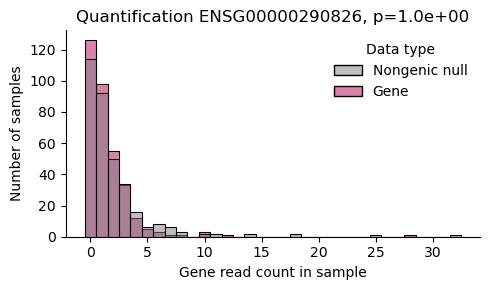

In [ ]:
sample_gene_id = 'ENSG00000290826'
plot_matched_null(sample_gene_id)
v11_median_tpm[v11_median_tpm['gene_id_stable'] == sample_gene_id]

,gene_id_stable,tpm,gene_type_grouped,match_level,new_highlight_gene_type,quantified
2,ENSG00000310526,0.682993,lncRNA,partial_match,lncRNA,True


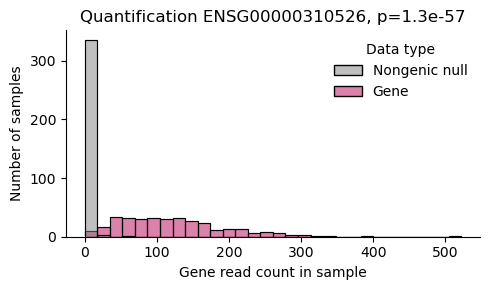

In [ ]:
sample_gene_id = 'ENSG00000310526'
plot_matched_null(sample_gene_id)
v11_median_tpm[v11_median_tpm['gene_id_stable'] == sample_gene_id]

In [ ]:
# add p values for all the genes
for idx, row in tqdm(v11_median_tpm.iterrows(), total=len(v11_median_tpm)):
    counts = v11_counts.loc[row['gene_id_stable']].values
    try:
        stat, p_value = stats.wilcoxon(counts, null_counts.loc[row['gene_id_stable']].values, alternative='greater')
    except ValueError as e:
        # if all are 0 or all are the same, then it is not qunatified
        # could give p value of 1, or could give nan and investigate further
        p_value = np.nan
    v11_median_tpm.loc[idx, 'matched_null_p'] = p_value
    v11_median_tpm.loc[idx, 'median_counts'] = np.median(counts)


  0%|          | 0/74590 [00:00<?, ?it/s]

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


<AxesSubplot: xlabel='matched_null_p', ylabel='Count'>

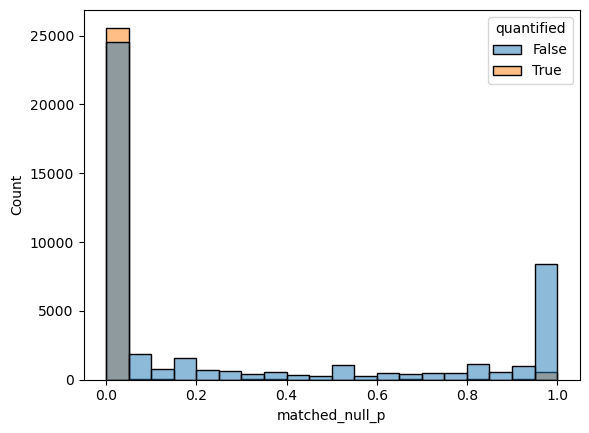

In [ ]:
sns.histplot(v11_median_tpm, x='matched_null_p', hue='quantified', bins=20)

In [ ]:
# one that is high tpm but not quantified
v11_median_tpm[(v11_median_tpm['tpm'] > 5) & (v11_median_tpm['matched_null_p'] >.9)]

,gene_id_stable,tpm,gene_type_grouped,match_level,new_highlight_gene_type,quantified,matched_null_p,median_counts
1379,ENSG00000163866,5.158814,protien_coding_or_TEC,id_match,protien_coding_or_TEC,True,1.0,1673.0
22704,ENSG00000198624,5.640064,protien_coding_or_TEC,id_match,protien_coding_or_TEC,True,1.0,846.0
42284,ENSG00000184743,7.154413,protien_coding_or_TEC,id_match,protien_coding_or_TEC,True,1.0,1968.0


Text(0, 0.5, 'p value from matched nongenic null')

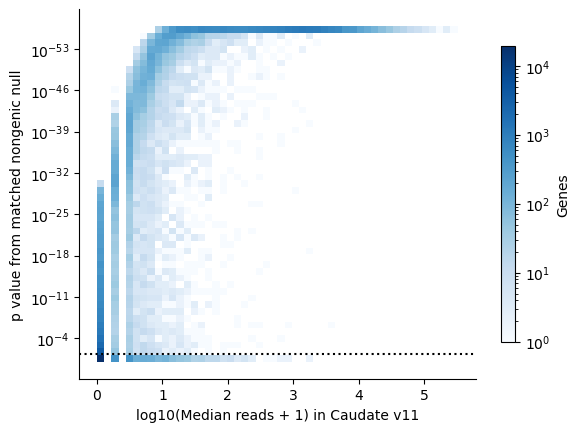

In [ ]:
v11_median_tpm['log_median_counts'] = np.log10(v11_median_tpm['median_counts'] + 1)
ax = sns.histplot(v11_median_tpm, x='log_median_counts', y='matched_null_p', log_scale=(False, True), bins=50, norm=LogNorm(),  
                  vmin=None, vmax=None,cbar=True, cmap=sns.color_palette("Blues", as_cmap=True), cbar_kws={'shrink':.8, 'label':'Genes'})
ax.invert_yaxis()
ax.axhline(0.05, color='k', ls=':')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('log10(Median reads + 1) in Caudate v11')
ax.set_ylabel('p value from matched nongenic null')

/local/scratch/klawren/slrmtmp.47796155/ipykernel_28732/562128276.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


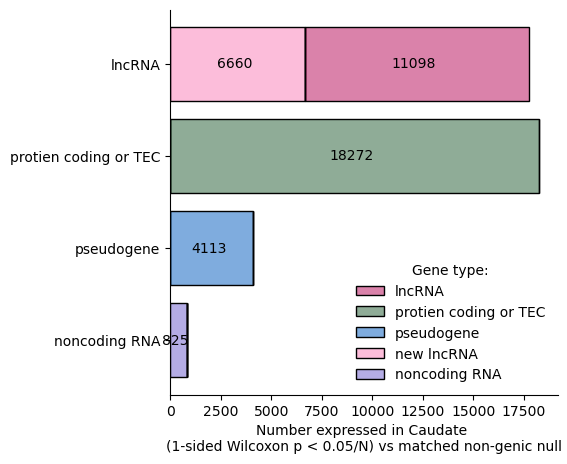

In [ ]:

fig, ax = plt.subplots(figsize=(5,5))

sns.histplot(v11_median_tpm[(v11_median_tpm['matched_null_p'] < (0.05/len(v11_median_tpm))) & ~(v11_median_tpm['gene_type_grouped'] == 'artifact')], y='gene_type_grouped', hue='new_highlight_gene_type', multiple='stack', 
             palette=highlight_gene_type_pal, alpha=0.5, shrink=.8, ax=ax)

# add numbers to plot
for container in ax.containers:
    labels = [f'{int(height)}' if height > 0 else '' for height in container.datavalues]
    ax.bar_label(container, labels=labels, padding=-2, fontsize=10, label_type='center')

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)
ax.set_ylabel('')
ax.set_xlabel('Number expressed in Caudate \n(1-sided Wilcoxon p < 0.05/N) vs matched non-genic null')

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gene type:")
for text in legend.get_texts():
    text.set_text(text.get_text().replace('_', ' '))

ax.spines[['top', 'right']].set_visible(False)


,gene_id_stable,tpm,gene_type_grouped,match_level,new_highlight_gene_type,quantified,matched_null_p,median_counts,log_median_counts
2,ENSG00000310526,0.682993,lncRNA,partial_match,lncRNA,True,1.271789e-57,113.0,2.056905
3,ENSG00000243485,0.000000,lncRNA,id_match,lncRNA,False,1.502408e-18,0.0,0.000000
8,ENSG00000186092,0.063332,protien_coding_or_TEC,id_match,protien_coding_or_TEC,False,1.437386e-33,6.0,0.845098
9,ENSG00000241860,0.037543,lncRNA,id_match,lncRNA,False,1.870587e-57,17.0,1.255273
11,ENSG00000233750,0.015803,pseudogene,id_match,pseudogene,False,5.625196e-08,2.0,0.477121
...,...,...,...,...,...,...,...,...,...
74551,ENSG00000237546,0.000000,pseudogene,id_match,pseudogene,False,9.168307e-16,0.0,0.000000
74557,ENSG00000299596,0.000000,lncRNA,partial_match,lncRNA,False,1.003133e-16,0.0,0.000000
74565,ENSG00000229238,0.000000,pseudogene,id_match,pseudogene,False,3.534479e-15,0.0,0.000000
74572,ENSG00000215506,0.000000,pseudogene,id_match,pseudogene,False,2.137206e-10,0.0,0.000000


/local/scratch/klawren/slrmtmp.47796155/ipykernel_28732/2474358792.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantified_by_null['gene_type_grouped'] = np.where(quantified_by_null['gene_type_grouped'] =='protien_coding_or_TEC', 'protien_coding', quantified_by_null['gene_type_grouped'])
/local/scratch/klawren/slrmtmp.47796155/ipykernel_28732/2474358792.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tissue_labels, fontsize=10)


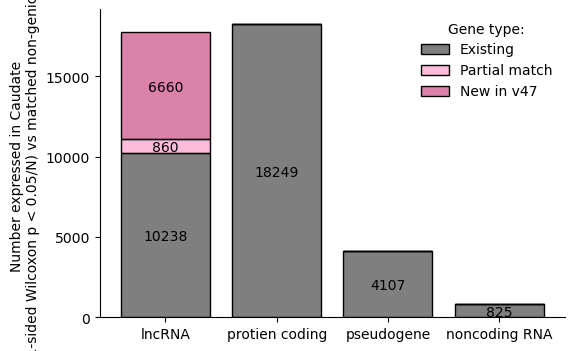

In [ ]:
# or color by if the gene is in gnecode v39
fig, ax = plt.subplots(figsize=(6, 4))
quantified_by_null = v11_median_tpm[(v11_median_tpm['matched_null_p'] < (0.05/len(v11_median_tpm))) & ~(v11_median_tpm['gene_type_grouped'] == 'artifact')]
quantified_by_null['gene_type_grouped'] = np.where(quantified_by_null['gene_type_grouped'] =='protien_coding_or_TEC', 'protien_coding', quantified_by_null['gene_type_grouped'])
sns.histplot(quantified_by_null, x='gene_type_grouped', hue='match_level', 
                  multiple='stack', alpha=0.5, shrink=.8, ax=ax,
                  palette=[ '#b70657', '#fb7cb6', 'black'],
                  hue_order=['unique_v47', 'partial_match', 'id_match'])

# add numbers to plot
for container in ax.containers:
    labels = [f'{int(height)}' if height > 20  else '' for height in container.datavalues]
    ax.bar_label(container, labels=labels, padding=-1, fontsize=10, label_type='center')

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_xticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_xticklabels(tissue_labels, fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Number expressed in Caudate \n(1-sided Wilcoxon p < 0.05/N) vs matched non-genic null')
ax.set_yticks([0, 5000, 10000, 15000])

# legend

ax.legend(['Existing', 'Partial match', 'New in v47'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gene type:")

ax.spines[['top', 'right']].set_visible(False)


### compare to v10 matched null

In [ ]:
#TODO from /home/klawren/oak/gtex/output/caudate_nongenic_null/v10_intergenic

#### bring in v8 matched null data for comparison

In [ ]:
# load in v10 matched null (only for lncRNAs)
v8_null = pd.read_excel('/home/klawren/oak/gtex/data/other_references/goede_2021.supp1.mmc2.xlsx', 
              sheet_name='Table_S1_lncRNA_expressionTests')
v8_null['gene_id_stable'] = v8_null['ensembl_gene_ID'].str.split('.').str[0]
v8_null_caudate = v8_null[['gene_id_stable', 'wilcox_pvalue_Brain_Caudate_basal_ganglia', 'median_reads_Brain_Caudate_basal_ganglia']]
v8_null_caudate = v8_null_caudate.rename(columns={'wilcox_pvalue_Brain_Caudate_basal_ganglia':'matched_null_p', 'median_reads_Brain_Caudate_basal_ganglia':'median_counts'})
v8_null_caudate['log_median_counts'] = np.log10(v8_null_caudate['median_counts'] + 1)

Text(0, 0.5, 'p value from matched nongenic null')

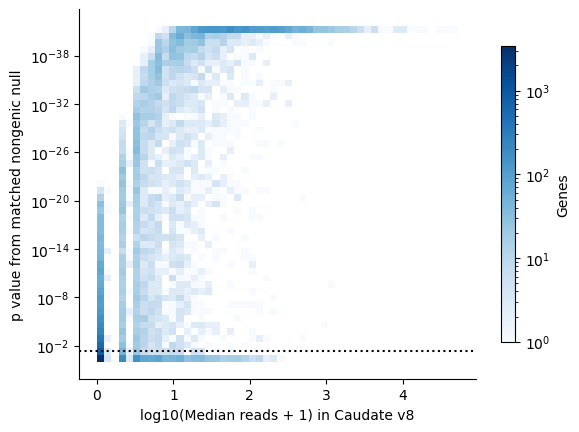

In [ ]:
ax = sns.histplot(v8_null_caudate, x='log_median_counts', y='matched_null_p', log_scale=(False, True), bins=50, norm=LogNorm(),  
                  vmin=None, vmax=None,cbar=True, cmap=sns.color_palette("Blues", as_cmap=True), cbar_kws={'shrink':.8, 'label':'Genes'})
ax.invert_yaxis()
ax.axhline(0.05, color='k', ls=':')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('log10(Median reads + 1) in Caudate v8')
ax.set_ylabel('p value from matched nongenic null')

Text(0.5, 1.0, 'Genes called as not quantified based on null comparison in v8')

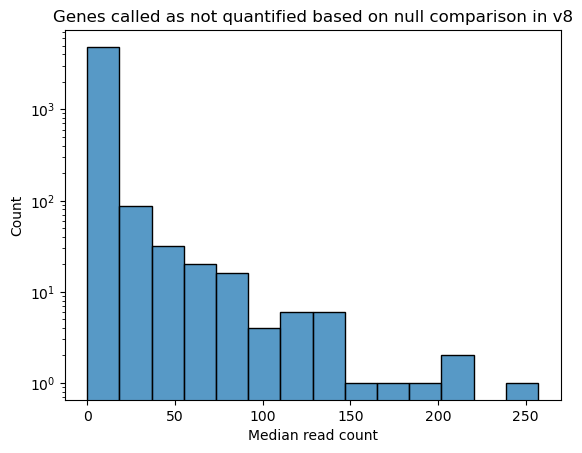

In [ ]:
ax = sns.histplot(v8_null_caudate[v8_null_caudate['matched_null_p'] > 0.05], x='median_counts')
ax.set_yscale('log')
ax.set_xlabel('Median read count')
ax.set_title('Genes called as not quantified based on null comparison in v8')

In [ ]:
merged_lncRNA_null = pd.merge(v11_median_tpm, v8_null_caudate, on='gene_id_stable', how='outer', suffixes=['_v11', '_v8'])
merged_lncRNA_null = merged_lncRNA_null[merged_lncRNA_null['gene_type_grouped'] == 'lncRNA']

Text(0, 0.5, 'log10(Median reads + 1) in Caudate v11')

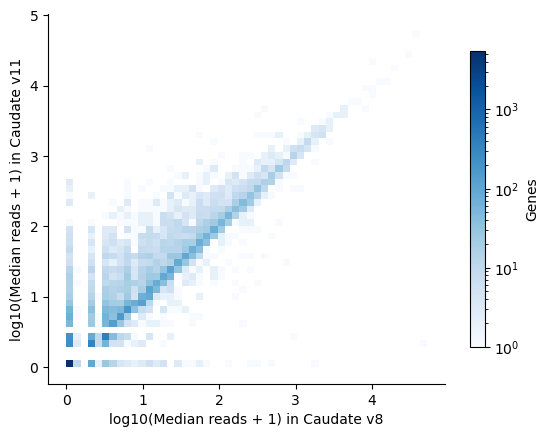

In [ ]:
ax = sns.histplot(merged_lncRNA_null, x='log_median_counts_v8', y='log_median_counts_v11', bins=50, norm=LogNorm(),  
                  vmin=None, vmax=None, cbar=True, cmap=sns.color_palette("Blues", as_cmap=True), cbar_kws={'shrink':.8, 'label':'Genes'})
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('log10(Median reads + 1) in Caudate v8')
ax.set_ylabel('log10(Median reads + 1) in Caudate v11')


In [ ]:
print('both sig: {}'.format(sum((merged_lncRNA_null['matched_null_p_v11'] < .05) & (merged_lncRNA_null['matched_null_p_v8'] < .05))))
print('neither sig: {}'.format(sum((merged_lncRNA_null['matched_null_p_v11'] > .05) & (merged_lncRNA_null['matched_null_p_v8'] > .05))))
print('v8 only sig: {}'.format(sum((merged_lncRNA_null['matched_null_p_v11'] < .05) & (merged_lncRNA_null['matched_null_p_v8'] > .05))))
print('v11 only sig: {}'.format(sum((merged_lncRNA_null['matched_null_p_v11'] > .05) & (merged_lncRNA_null['matched_null_p_v8'] < .05))))

both sig: 7079
neither sig: 2098
v8 only sig: 2404
v11 only sig: 953
